In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import pytide
import utm

dir = './FES2014-PCP'


In [2]:
archivos = os.listdir(os.path.join(dir, 'ocean_tide_extrapolated_PCP'))

# Verificar que la lista de archivos tiene 34 elementos
print(len(archivos))


34


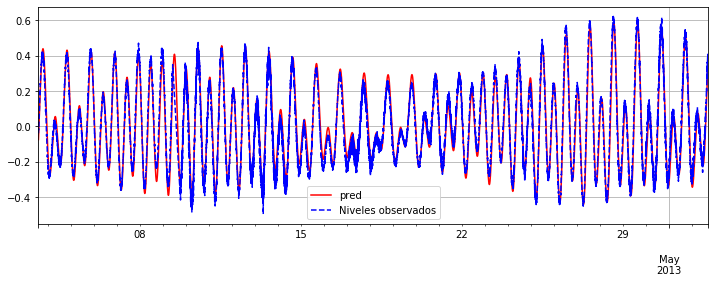

In [6]:
# Cargar datos de niveles
niveles = pd.read_excel('ADCP NIVELES.xlsx', usecols=['Fecha y hora local', 'Nivel del mar (m)'])
niveles['Fecha y hora local'] = pd.to_datetime(niveles['Fecha y hora local']).dt.floor('min')
niveles.set_index('Fecha y hora local', inplace=True)

# Ajustar el huso horario de la serie observada
niveles.index = niveles.index + pd.Timedelta(hours=5)

# Ajuste del nivel del mar restando la media
niveles['Nivel del mar (m)'] -= niveles['Nivel del mar (m)'].mean()

# Ajustar los intervalos de tiempo a cada 5 minutos
niveles = niveles.resample('5T').mean().interpolate()

# Verificar latitud y longitud
lat0, lon0 = utm.to_latlon(505523, 8285343, 18, northern=False)
lon0 = lon0 % 360  # Asegurar que la longitud esté en el rango de 0 a 360°

# Inicializar listas para nombres, fases y amplitudes
nom, fase, amp = [], [], []

# Listar archivos en el directorio
archivos = [f for f in os.listdir(os.path.join(dir, 'ocean_tide_extrapolated_PCP')) if f.endswith('.nc')]

# Procesar archivos para obtener fases y amplitudes
for arch in archivos:
    datos = xr.open_dataset(os.path.join(dir, 'ocean_tide_extrapolated_PCP', arch)).sel(lon=lon0, lat=lat0, method="nearest")
    nom.append(arch[:-3])
    fase.append(datos.phase.data)
    amp.append(datos.amplitude.data)

# Crear DataFrame con los datos de constantes
constantes = pd.DataFrame(data=zip(nom, amp, fase), columns=['Name', 'amplitude', 'phase'])

# Configurar pytide
nombres = pd.read_csv('nombresFES_pytide.csv', sep=';')
wt = pytide.WaveTable(nombres.pytide)

# Calcular modulaciones nodales
fecha_min = niveles.index.min()
fecha_max = niveles.index.max().round('min')
tiempo = pd.date_range(start=fecha_min, end=fecha_max, freq='5min')
f, vu = wt.compute_nodal_modulations(tiempo.values)

def predi(tabla, facto, vum, fecha):
    H = tabla.amplitude
    K = tabla.phase
    Q = len(f)
    ondas = pd.DataFrame()
    for i in range(Q):
        ondas.insert(i, i, H[i] * facto[i, :] * np.cos(vum[i, :] - np.radians(K[i])))
    suma = ondas.sum(axis=1).values
    # Convertir de cm a m
    suma = suma / 100
    prediccion = pd.DataFrame(suma, fecha, columns=['pred'])
    return ondas, prediccion

# Realizar predicción de mareas
onda, marea = predi(constantes, f, vu, tiempo.values)

# Asegurarse de que los índices coincidan
niveles = niveles.reindex(tiempo)

# Visualización de los datos ajustados
fig, axs = plt.subplots(1, 1, figsize=(12, 4))
marea.plot(ax=axs, color='r', label='Predicción de marea')
niveles['Nivel del mar (m)'].plot(ax=axs, label='Niveles observados', style='b--')
axs.legend()
axs.grid()
plt.show()